In [1]:
# Implementation of https://www.roboticsbook.org/S64_driving_perception.html#the-poseslam-factor-graph

In [18]:
import gtsam
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import cv2
import os
from visual_odometry import VisualOdometry
from gtsam.utils import plot
from numpy.linalg import inv
from math import pi
from lib.visualization import plotting
from lib.util import load_poses

In [19]:
# Load images for VO
path = "./00/images/"

images = []
print("Loading images")
for fname in tqdm(os.listdir(path)):
        images.append((cv2.imread(os.path.join(path, fname), 0), fname))

# Sort images and remove names after sorting
images = sorted(images, key = lambda x: x[1])
images = list(map(lambda x: x[0], images))

Loading images


100%|██████████| 4541/4541 [00:21<00:00, 210.76it/s]


In [20]:
# Load ground truth poses
poses_gt = load_poses("data_odometry_poses/dataset/poses/00.txt")
print(poses_gt[0])
print(f"Loaded {len(poses_gt)} poses")

[[ 1.000000e+00  9.043680e-12  2.326809e-11  5.551115e-17]
 [ 9.043683e-12  1.000000e+00  2.392370e-10  3.330669e-16]
 [ 2.326810e-11  2.392370e-10  9.999999e-01 -4.440892e-16]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
Loaded 4541 poses


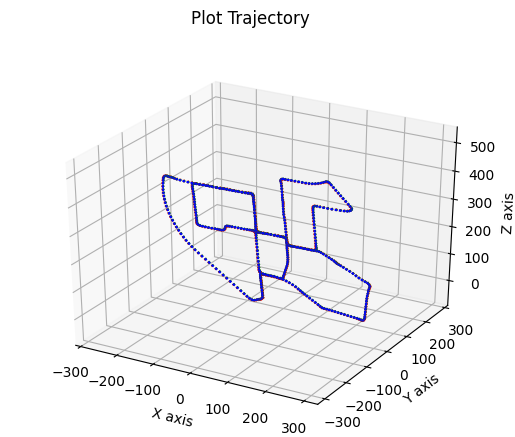

In [33]:
### draw the gt poses 
test = gtsam.Values()
for ii, pose_gt in enumerate(poses_gt):
    if ii % 10 == 0:
        test.insert(ii, gtsam.Pose3(pose_gt))

# Plot GT trajectory
plot.plot_trajectory(1, test, scale=1.5)
plot.set_axes_equal(True)
plt.show()

In [34]:
# load pose estimates
poses = None
with open('00/pose_estimates.json', 'r') as f:
    poses = json.load(f)["poses"]

# convert to python arrays
poses = list(map(lambda x: np.asarray(x), poses))
print(poses[0])
print(f"Loaded {len(poses)} poses")

[[ 1.000000e+00  9.043680e-12  2.326809e-11  5.551115e-17]
 [ 9.043683e-12  1.000000e+00  2.392370e-10  3.330669e-16]
 [ 2.326810e-11  2.392370e-10  9.999999e-01 -4.440892e-16]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
Loaded 4541 poses


[[ 1.000000e+00  9.043680e-12  2.326809e-11  5.551115e-17]
 [ 9.043683e-12  1.000000e+00  2.392370e-10  3.330669e-16]
 [ 2.326810e-11  2.392370e-10  9.999999e-01 -4.440892e-16]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]


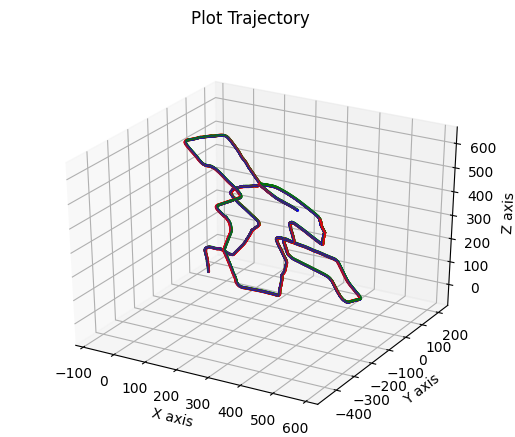

In [31]:
# Create the initial estimates
initial_estimate = gtsam.Values()
for i in range(len(poses)):
    pose = gtsam.Pose3(poses[i])
    initial_estimate.insert(i, pose)

# Plot initial estimate
plot.plot_trajectory(1, initial_estimate, scale=1.5)
plot.set_axes_equal(True)
plt.show()

In [39]:
graph = gtsam.NonlinearFactorGraph()
prior_model = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4]))
graph.add(gtsam.PriorFactorPose3(1, gtsam.Pose3(), prior_model))

# Create odometry (Between) factors between consecutive poses
odometry_model = gtsam.noiseModel.Diagonal.Sigmas((0.005, 0.005, 0.005, 0.01, 0.01,0.01))
Between = gtsam.BetweenFactorPose3

curr_pose = np.eye(4)
curr_pose[0,3] = 0.01

edges = []

for ii in range(len(poses) - 1):
    transf = poses[ii] @ inv(curr_pose)
    graph.add(Between(ii, ii + 1, gtsam.Pose3(transf), odometry_model))
    edges.append(transf)
    curr_pose = poses[ii]

# Add the loop closure constraint
data_dir = "00"
vo = VisualOdometry(data_dir, load_data=False)
loops_indexes = [(4448,1)] # we know that there is a loop between these images

for loops_index_pair in loops_indexes:
    idx_from = loops_index_pair[0] # index of current pose
    idx_to = loops_index_pair[1] # index of matching pose

    ## calculate the delta between these two images using VO 
    loop_gt = poses_gt[idx_from] @ inv(poses_gt[idx_to])
    graph.add(Between(idx_to, idx_from, gtsam.Pose3(loop_gt), odometry_model))

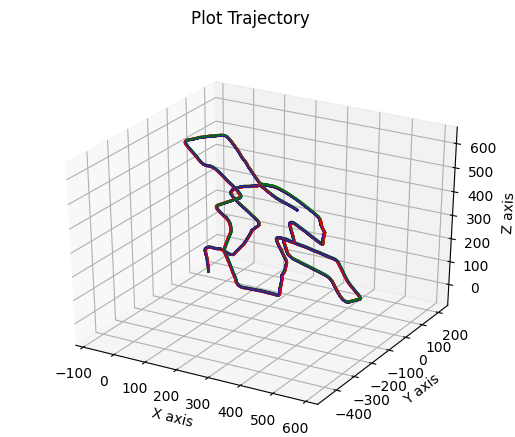

In [24]:
### draw the pose estimates from odometries
test = gtsam.Values()
curr_pose = np.eye(4)
for ii, odom in enumerate(edges):
    curr_pose = odom @ curr_pose
    test.insert(ii, gtsam.Pose3(curr_pose))

# Plot GT trajectory
plot.plot_trajectory(1, test, scale=1.5)
plot.set_axes_equal(True)
plt.show()

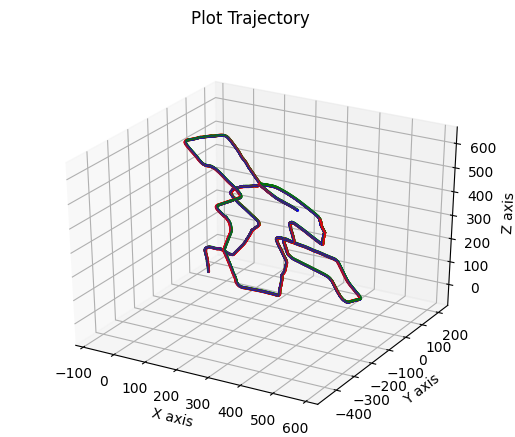

In [35]:
# Create the initial estimate
initial_estimate = gtsam.Values()
for i in range(len(poses)):
    pose = gtsam.Pose3(poses[i])
    initial_estimate.insert(i, pose)

# Plot initial estimate
plot.plot_trajectory(1, initial_estimate, scale=1.5)
plot.set_axes_equal(True)
plt.show()

In [36]:
# Optimize the initial values using a Gauss-Newton nonlinear optimizer
params = gtsam.GaussNewtonParams()

optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, params)
result = optimizer.optimize()

print("Optimization complete")
print("initial error = ", graph.error(initial_estimate))
print("final error = ", graph.error(result))

Optimization complete
initial error =  5509058942.618118
final error =  2723927.274342363


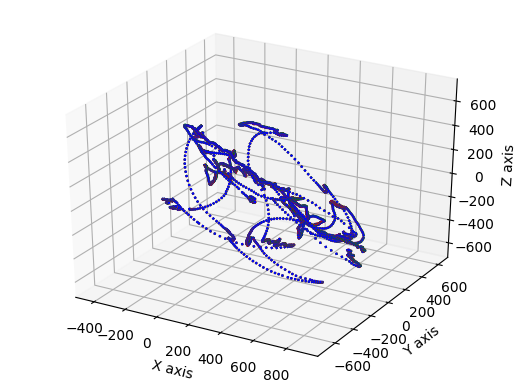

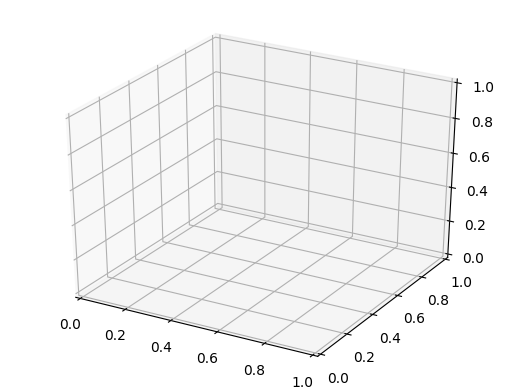

In [40]:
marginals = gtsam.Marginals(graph, result)
plot.plot_incremental_trajectory(3, result, scale=1.5, time_interval=0.1, marginals=marginals)
plot.set_axes_equal(True)

In [41]:
estimated_path = []
original_path = []

print(result.atPose3(0).translation())
for i in range(len(poses)):
    pose = result.atPose3(i)
    estimated_path.append((pose.x(), pose.z()))
    original_path.append((poses_gt[i][0, 3], poses_gt[i][2,3]))

plotting.visualize_paths(original_path, estimated_path, "Visual Odometry", file_out=os.path.basename("trajectory") + ".html")

[ 1.00000000e-02 -9.39766852e-15  3.73900937e-12]
